In [1]:
!pwd

/teamspace/studios/this_studio


In this notebook we will explore Open Images dataset. [Open Images](https://storage.googleapis.com/openimages/web/index.html) is a dataset of ~9M images annotated with image-level labels, object bounding boxes, object segmentation masks, visual relationships, and localized narratives. It contains a total of 16M bounding boxes for 600 object classes on 1.9M images, making it the largest existing dataset with object location annotations.

In [2]:
import os
os.chdir('object_detection/raw_data/')
ROOT = os.getcwd()
ROOT

'/teamspace/studios/this_studio/object_detection/raw_data'

In [4]:
!mkdir -p OI_v5

In [3]:
os.chdir("OI_v5")

In [4]:
import os
import numpy as np
import pandas as pd
import cv2
import tqdm
import urllib.request
from PIL import Image
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)

# Downloading the CSV's

In [7]:
# Training bounding boxes (1.11G)
!wget https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv

# Validating bounding boxes (23.94M)
!wget https://storage.googleapis.com/openimages/v5/validation-annotations-bbox.csv
    
# Testing bounding boxes (73.89M)
!wget https://storage.googleapis.com/openimages/v5/test-annotations-bbox.csv

# Class names of images (11.73K)
!wget https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv

--2024-03-08 09:03:15--  https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.167.207, 142.251.16.207, 172.253.62.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.167.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1194033454 (1.1G) [text/csv]
Saving to: ‘train-annotations-bbox.csv’

          train-ann   0%[                    ]       0  --.-KB/s               

train-annotations-b 100%[===================>]   1.11G   151MB/s    in 8.7s    

2024-03-08 09:03:24 (131 MB/s) - ‘train-annotations-bbox.csv’ saved [1194033454/1194033454]

--2024-03-08 09:03:24--  https://storage.googleapis.com/openimages/v5/validation-annotations-bbox.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.163.207, 172.253.63.207, 172.253.122.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.163.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25105048 (24M) [text/csv]
Saving to: ‘validation-annotations-bbox.csv’

validation-annotati 100%[===================>]  23.94M  52.7MB/s    in 0.5s    

2024-03-08 09:03:24 (52.7 MB/s) - ‘validation-annotations-bbox.csv’ saved [25105048/25105048]

--2024-03-08 09:03:25--  https://storage.googleapis.com/openimages/v5/test-annotations-bbox.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.163.207, 172.253.63.207, 172.253.122.207, ..

Obtain `downloadOI.py` from [learnopencv's tutorial](https://www.learnopencv.com/fast-image-downloader-for-open-images-v4/) to download specific classes from Open Image v5.

- Taken Classes
 + Boat
 + Bicycle
 + Bottle

In [10]:
!python3 /teamspace/studios/this_studio/object_detection/open-images-v5/downloadOI.py --classes 'Boat,Bicycle' --mode train

Class 0 : Boat


Class 1 : Bicycle
Annotation Count : 119274
Number of images to be downloaded : 43109
100%|███████████████████████████████████| 43109/43109 [3:48:22<00:00,  3.15it/s]


# Exploring

## Label Description

In [5]:
labels = pd.read_csv("class-descriptions-boxable.csv", header=None, names=['LabelName', 'Label'])
labels.sample(5)

,LabelName,Label
69,/m/01g3x7,Bow and arrow
57,/m/01d40f,Dress
448,/m/0by6g,Shark
520,/m/0ft9s,Dragonfly
381,/m/07c6l,Trombone


In [6]:
picked_labels = ['Boat','Bicycle']
subset_labels = labels[labels['Label'].isin(picked_labels)]
subset_labels

,LabelName,Label
39,/m/0199g,Bicycle
42,/m/019jd,Boat


## Label Hierarchy

In [8]:
!wget https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy.json

--2024-03-09 08:58:43--  https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy.json
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.115.207, 172.253.62.207, 142.251.16.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.115.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86291 (84K) [text/csv]
Saving to: ‘bbox_labels_600_hierarchy.json’

bbox_labels_600_hie 100%[===================>]  84.27K  --.-KB/s    in 0.005s  

2024-03-09 08:58:43 (15.5 MB/s) - ‘bbox_labels_600_hierarchy.json’ saved [86291/86291]



In [9]:
import ast

with open("bbox_labels_600_hierarchy.json", 'r') as f:
    hierary = f.read()
    
for row in range(len(labels)):
    row = labels.iloc[row, :]
    # print(row)
    hierary = hierary.replace(row[0], row[1])

hierary = ast.literal_eval(hierary)
print(type(hierary))
hierary

<class 'dict'>


/tmp/ipykernel_4656/325404355.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hierary = hierary.replace(row[0], row[1])


{'LabelName': '/m/0bl9f',
 'Subcategory': [{'LabelName': 'Coin'},
  {'LabelName': 'Flag'},
  {'LabelName': 'Light bulb'},
  {'LabelName': 'Toy',
   'Subcategory': [{'LabelName': 'Doll'},
    {'LabelName': 'Balloon'},
    {'LabelName': 'Dice'},
    {'LabelName': 'Flying disc'},
    {'LabelName': 'Kite'},
    {'LabelName': 'Teddy bear'}]},
  {'LabelName': 'Home appliance',
   'Subcategory': [{'LabelName': 'Washing machine'},
    {'LabelName': 'Toaster'},
    {'LabelName': 'Oven'},
    {'LabelName': 'Blender'},
    {'LabelName': 'Gas stove'},
    {'LabelName': 'Mechanical fan'},
    {'LabelName': 'Heater'},
    {'LabelName': 'Kettle'},
    {'LabelName': 'Hair dryer'},
    {'LabelName': 'Refrigerator'},
    {'LabelName': 'Wood-burning stove'},
    {'LabelName': 'Humidifier'},
    {'LabelName': 'Mixer'},
    {'LabelName': 'Coffeemaker'},
    {'LabelName': 'Microwave oven'},
    {'LabelName': 'Dishwasher'},
    {'LabelName': 'Sewing machine'},
    {'LabelName': 'Hand dryer'},
    {'LabelName

In [10]:
# Display a portion of all classes
hierary['Subcategory'][:5]

[{'LabelName': 'Coin'},
 {'LabelName': 'Flag'},
 {'LabelName': 'Light bulb'},
 {'LabelName': 'Toy',
  'Subcategory': [{'LabelName': 'Doll'},
   {'LabelName': 'Balloon'},
   {'LabelName': 'Dice'},
   {'LabelName': 'Flying disc'},
   {'LabelName': 'Kite'},
   {'LabelName': 'Teddy bear'}]},
 {'LabelName': 'Home appliance',
  'Subcategory': [{'LabelName': 'Washing machine'},
   {'LabelName': 'Toaster'},
   {'LabelName': 'Oven'},
   {'LabelName': 'Blender'},
   {'LabelName': 'Gas stove'},
   {'LabelName': 'Mechanical fan'},
   {'LabelName': 'Heater'},
   {'LabelName': 'Kettle'},
   {'LabelName': 'Hair dryer'},
   {'LabelName': 'Refrigerator'},
   {'LabelName': 'Wood-burning stove'},
   {'LabelName': 'Humidifier'},
   {'LabelName': 'Mixer'},
   {'LabelName': 'Coffeemaker'},
   {'LabelName': 'Microwave oven'},
   {'LabelName': 'Dishwasher'},
   {'LabelName': 'Sewing machine'},
   {'LabelName': 'Hand dryer'},
   {'LabelName': 'Ceiling fan'}]}]

# Train Data 

The annotations are saved in a `csv` file, where each line represents a box. We can inner join the annotation file with `subset_labels` to extract annotations of our target classes only.

In [11]:
train_df = pd.read_csv("train-annotations-bbox.csv")
train_df = train_df.merge(subset_labels, on='LabelName')
train_df.sample(5)

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,Label
72531,e92b60cf7a4ebc7e,activemil,/m/019jd,1,0.101377,0.814768,0.297552,0.617702,0,0,0,0,0,Boat
79100,fff3f6048654f5d1,xclick,/m/019jd,1,0.578125,0.634375,0.537736,0.630624,1,0,0,1,0,Boat
54562,ad4fe66da1927fc4,xclick,/m/019jd,1,0.105625,0.192500,0.401501,0.484991,0,0,0,0,0,Boat
52421,a62519240426d692,xclick,/m/019jd,1,0.545000,0.583750,0.444836,0.468310,0,0,0,0,0,Boat
70040,e069c45e7f83a884,xclick,/m/019jd,1,0.721250,0.814375,0.606542,0.659813,1,0,0,0,0,Boat


In [25]:
train_df['ImageID'].nunique()

43078

Text(0, 0.5, 'Count')

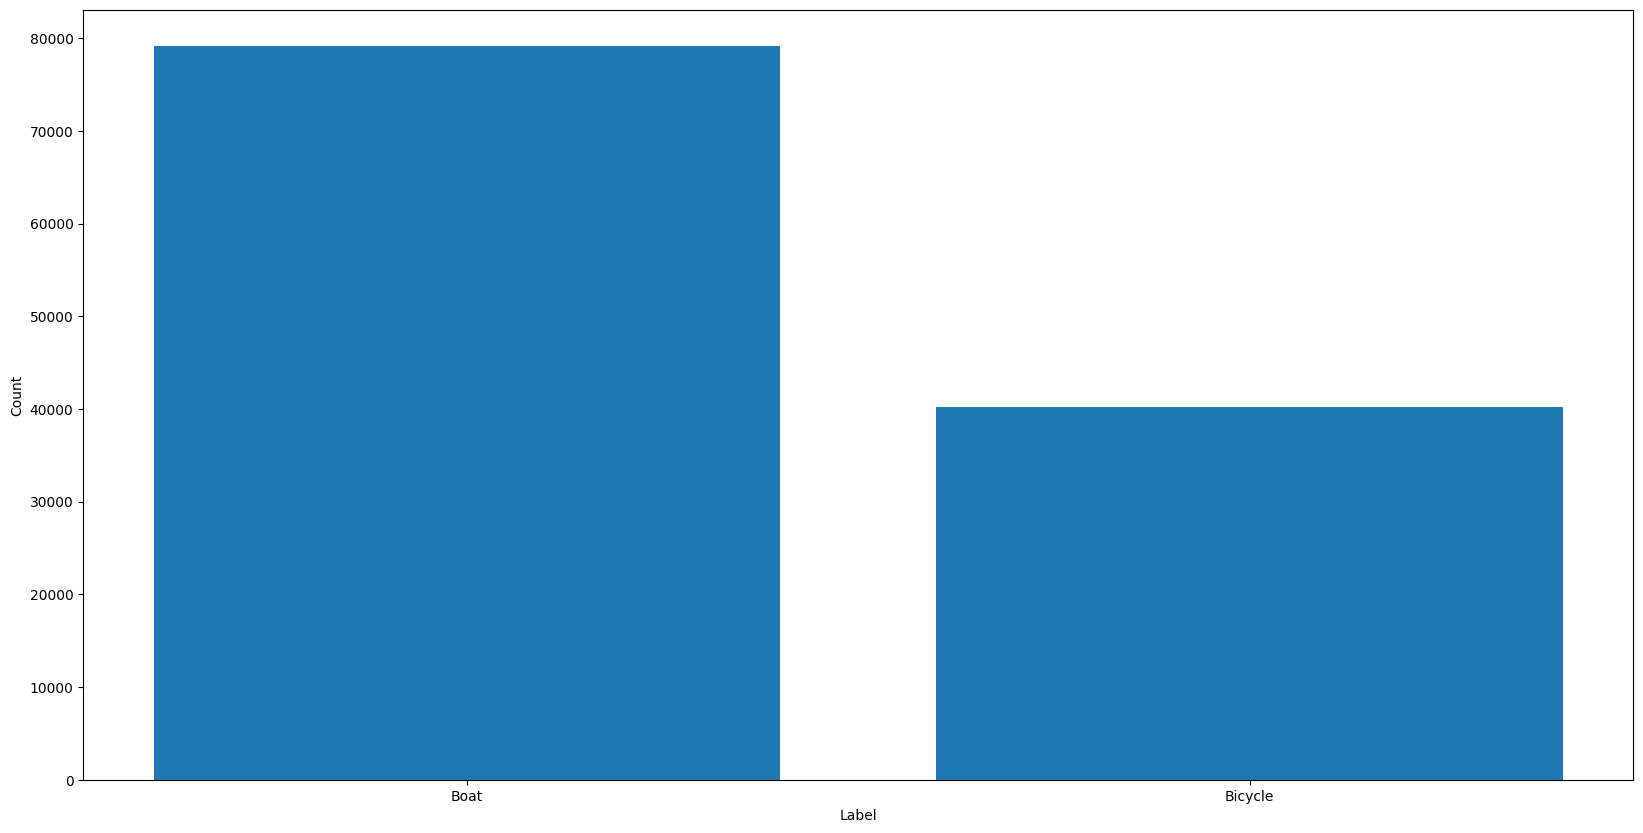

In [12]:
plt.bar(train_df['Label'].unique(), train_df['Label'].value_counts())
plt.xlabel('Label')
plt.ylabel('Count')

In [13]:
train_df.groupby('ImageID')['Label'].nunique().value_counts()

Label
1    43047
2       31
Name: count, dtype: int64

In [14]:
# Get images containing 2 classes
label_counts = train_df.groupby('ImageID')['Label'].nunique()
img_with_two_labels = label_counts.index[label_counts == 2].tolist()
img_with_two_labels

['180c0fa3247adef5',
 '1aa5a8f4f5a28219',
 '1d21496898a945b6',
 '2c1bcf9fc3759ecb',
 '31082c48aa5f0758',
 '31ae62ed92a1d088',
 '3be36e154a146a38',
 '442109e773864512',
 '4899a287adfd1d04',
 '516f8163a385a318',
 '613792048e4e2418',
 '68be7375e314e053',
 '749f6a43013aafca',
 '7803703a1de010e3',
 '7bf1457fa7de82b9',
 '80ef544e6a55d355',
 '810abf5017ed5329',
 '819ba5345067df21',
 '88066f1566c14c6c',
 '91f17c66496fea35',
 '989c95f55b3be2a5',
 'b31150a62fc685c9',
 'b74265a561fcf64f',
 'b8b7624f99e73eba',
 'ba53f4a79f9f008e',
 'c8249e908cff81d7',
 'c8c1078051522ca2',
 'd4be1d6f22c29d7f',
 'db7b62c02de0f5da',
 'deabb9f825c255ab',
 'f5d7725f9be7e4e1']

7bf1457fa7de82b9


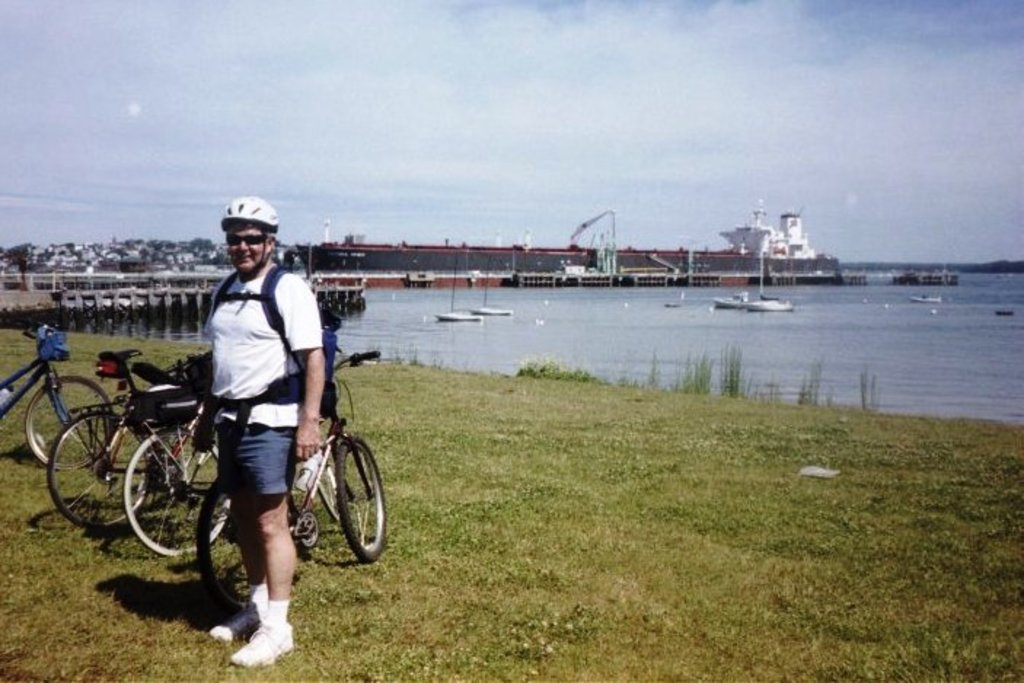

In [15]:
img_id = np.random.choice(img_with_two_labels)
print(img_id)
im = Image.open(f"train/Bicycle/{img_id}.jpg")
im = Image.open(f"train/Boat/{img_id}.jpg")
im

In [36]:
COLORS = [
    [0.000, 0.447, 0.741], 
    [0.850, 0.325, 0.098], 
    [0.929, 0.694, 0.125],
    [0.494, 0.184, 0.556], 
    [0.466, 0.674, 0.188], 
    [0.301, 0.745, 0.933]]

def denormalize_bbox(bbox, height, width):
    bbox[:, [0,2]] = bbox[:, [0,2]] * width
    bbox[:, [1,3]] = bbox[:, [1,3]] * height
    return bbox

def plot_box(img, bbox, cls):
    plt.figure(figsize=(12,10))
    plt.imshow(img)
    ax = plt.gca()
    for box, cl, c in zip(bbox.tolist(), cls, COLORS*100):
        x_min, y_min, x_max, y_max = box 
        ax.add_patch(plt.Rectangle((x_min,y_min), x_max-x_min, y_max-y_min, fill=False, color=c, linewidth=1.5) )
        ax.text(x_min, y_min, cl, fontsize=10,bbox=dict(facecolor='yellow', alpha=0.3))
    plt.axis('off')
    plt.show()

[[0.294452 0.285714 0.829303 0.41791 ]
 [0.422475 0.371002 0.462304 0.473348]
 [0.462304 0.366738 0.506401 0.469083]
 [0.697013 0.426439 0.726885 0.458422]
 [0.726885 0.424307 0.775249 0.454158]
 [0.88478  0.428571 0.918919 0.439232]
 [0.       0.471215 0.110953 0.682303]
 [0.039829 0.501066 0.207681 0.782516]
 [0.194879 0.513859 0.379801 0.812367]]


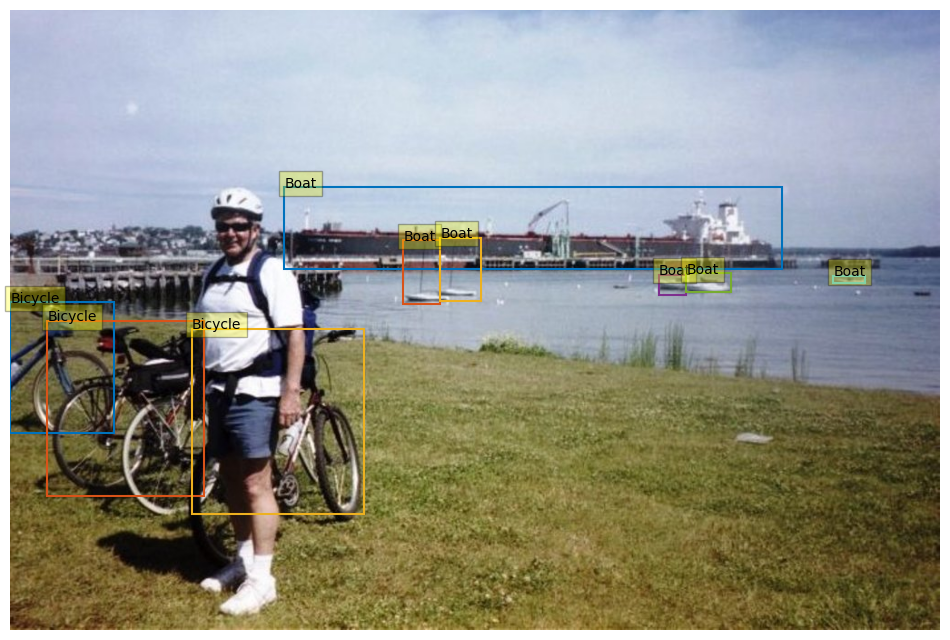

In [37]:
# Denormalize bboxes
height, width = np.array(im).shape[:2]
bboxes = train_df[train_df['ImageID'] == img_id][['XMin', 'YMin', 'XMax', 'YMax']].values
print(bboxes)
bboxes = denormalize_bbox(bboxes, height, width)

# Get class label
classes = train_df[train_df['ImageID'] == img_id]['Label'].values

# Plot
plot_box(im, bboxes, classes)